In [1]:
from os import path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm.notebook import tqdm

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import StimulusAnalysis, DriftingGratings
import allen_v1dd.stimulus_analysis.analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
metrics_all = at.load_roi_metrics(add_columns=True, remove_invalid=False, remove_duplicates=False)

# Only consider valid metrics
n_before = len(metrics_all)
metrics_all = metrics_all[metrics_all.is_valid & (metrics_all.mouse == 409828) & (metrics_all.column == 1)]
print(f"Only considering valid ROIs in M409828 and Column 1: {len(metrics_all)} / {n_before} ({len(metrics_all)/n_before*100:.1f}%)")

metrics_all

Only considering valid ROIs in M409828 and Column 1: 9714 / 52826 (18.4%)


,mouse,column,volume,plane,roi,is_valid,is_ignored_duplicate,has_duplicate,n_duplicates,duplicate_rois,...,spontaneous_event_mean,spontaneous_event_std,depth_chunk,depth_trunc,vol_plane,dgw_is_responsive,dgf_is_responsive,ssi_fit,dgw_pref_dir_fit,dgf_pref_dir_fit
M409828_11_1_89,409828,1,1,1,89,True,False,False,0,NaN,...,0.000287,0.001903,0,0,1-1,False,False,-0.043955,30.681108,69.313722
M409828_11_2_0,409828,1,1,2,0,True,False,True,2,"M409828_11_2_0, M409828_11_3_2",...,0.000346,0.002629,0,0,1-2,False,False,-0.073683,61.781378,43.508462
M409828_11_2_1,409828,1,1,2,1,True,False,True,2,"M409828_11_2_1, M409828_11_3_0",...,0.000341,0.002262,0,0,1-2,True,True,-0.011145,20.539986,13.115250
M409828_11_2_2,409828,1,1,2,2,True,False,False,0,NaN,...,0.000341,0.002412,0,0,1-2,True,True,0.278888,360.000000,66.145993
M409828_11_2_4,409828,1,1,2,4,True,False,False,0,NaN,...,0.000234,0.001601,0,0,1-2,False,False,-0.100974,348.754021,307.709808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M409828_1f_1_67,409828,1,f,1,67,True,False,False,0,NaN,...,0.001101,0.007307,10,700,f-1,False,False,0.126505,149.640456,37.085351
M409828_1f_1_69,409828,1,f,1,69,True,False,False,0,NaN,...,0.001627,0.010508,10,700,f-1,False,False,0.331093,186.314212,314.004962
M409828_1f_1_70,409828,1,f,1,70,True,False,False,0,NaN,...,0.001108,0.006967,10,700,f-1,False,True,-0.425755,214.434681,325.832316
M409828_1f_1_74,409828,1,f,1,74,True,False,False,0,NaN,...,0.000818,0.005215,10,700,f-1,False,False,-0.217209,141.171582,130.039470


In [4]:
# Insert new metrics columns for analysis
metrics_all["depth_chunk"] = metrics_all.apply(lambda row: min(int(np.floor((row.depth - 50) / 48)), 10), axis=1) # 50 is shallowest depth; 48 is size of chunk; deeper chunks go to 10
metrics_all["vol_plane"] = metrics_all.apply(lambda row: f"{row.volume}-{row.plane}", axis=1)
print("depth_chunk value counts:")
print(metrics_all["depth_chunk"].value_counts().sort_index())

# Compute layer
# def get_layer_name(depth):
#     for i, (layer_name, depth_min) in enumerate(zip(V1DDEMClient.LAYER_NAMES, V1DDEMClient.LAYER_BOUNDARIES)):
#         if depth < depth_min:
#             # We have found the layer
#             return layer_name

#     return "Deep"

# metrics_all["layer"] = metrics_all.depth.apply(get_layer_name)
# print(metrics_all["layer"].value_counts().sort_index())

depth_chunk value counts:
0       36
1      551
2      985
3     1081
4     1362
5     1346
6     1307
7      910
8      623
9      589
10     924
Name: depth_chunk, dtype: int64


In [4]:
print(f"There are {metrics_all.has_duplicate.sum()}/{len(metrics_all)} total duplicates")
print(f"Of the duplicates, {(metrics_all.has_duplicate & metrics_all.is_ignored_duplicate).sum()}/{metrics_all.has_duplicate.sum()} are discarded and {(metrics_all.has_duplicate & ~metrics_all.is_ignored_duplicate).sum()}/{metrics_all.has_duplicate.sum()} are kept for analysis")

metrics = metrics_all[~metrics_all.is_ignored_duplicate].copy()
print(f"Number of ROIs not duplicate: {len(metrics)}")

There are 3660/9714 total duplicates
Of the duplicates, 2250/3660 are discarded and 1410/3660 are kept for analysis
Number of ROIs not duplicate: 7464


In [5]:
# Load the metrics with additional columns
metrics = at.load_roi_metrics()
metrics = metrics[(metrics.mouse == 409828) & (metrics.column == 1)]

# Generate files to send to EM team on interesting ROIs

In [80]:
INDEX_PRIORITY = []

is_dgf_responsive = metrics.dgf_frac_responsive_trials >= 0.5

for dgf_responsive in ((True, False)):
    df = metrics[(metrics.volume == 3) & (metrics.dgw_frac_responsive_trials >= 0.5) & (is_dgf_responsive if dgf_responsive else ~is_dgf_responsive)].copy()
    new_idx = []
    df.sort_values("ssi", ascending=False, inplace=True)
    # df.sort_values("dgw_chisq_response_p", ascending=True, inplace=True)

    indices = list(df.index.values)

    while len(indices) > 0:
        # Pop first n items from list
        n = 8 # Include more high SSI cells
        new_idx.extend(indices[:n])
        del indices[:n]

        # Pop last n items from list (in reversed order)
        n = 4
        new_idx.extend(indices[-n:][::-1])
        del indices[-n:]

    # df = df.loc[new_idx]
    INDEX_PRIORITY.extend(new_idx)

metrics.loc[INDEX_PRIORITY][["dgw_frac_responsive_trials", "dgf_frac_responsive_trials", "ssi", "dgw_chisq_response_p"]].head(24)

# df = pd.DataFrame(columns=["roi_full", "ophys_column", "ophys_volume", "ophys_plane", "ophys_roi"])

# for roi_full in INDEX_PRIORITY:
#     mouse, colvol, plane, roi = roi_full.split("_")
#     df.loc[len(df)] = (roi_full, 1, 3, f"plane{int(plane)-1}", f"roi_{roi.zfill(4)}")

# df.to_csv("/Users/chase/Desktop/ophys_13_rois_for_em.csv", index=False)
# df

,dgw_frac_responsive_trials,dgf_frac_responsive_trials,ssi,dgw_chisq_response_p
M409828_13_4_27,0.750000,0.500000,0.958255,0.002
M409828_13_4_50,1.000000,0.750000,0.951606,0.000
M409828_13_3_77,1.000000,0.750000,0.945664,0.000
M409828_13_3_210,0.750000,0.500000,0.937284,0.050
M409828_13_2_74,1.000000,0.857143,0.934752,0.000
M409828_13_3_12,0.750000,0.714286,0.929051,0.122
M409828_13_2_30,0.875000,0.857143,0.928388,0.000
M409828_13_6_0,0.857143,0.500000,0.916505,0.000
M409828_13_1_26,0.625000,1.000000,-0.870532,0.006
M409828_13_3_29,0.625000,1.000000,-0.828736,0.000


In [66]:
df.ophys_plane.value_counts()

plane5    102
plane4     85
plane3     79
plane2     77
plane1     76
plane0     66
Name: ophys_plane, dtype: int64

<AxesSubplot: xlabel='has_duplicate', ylabel='depth_chunk'>

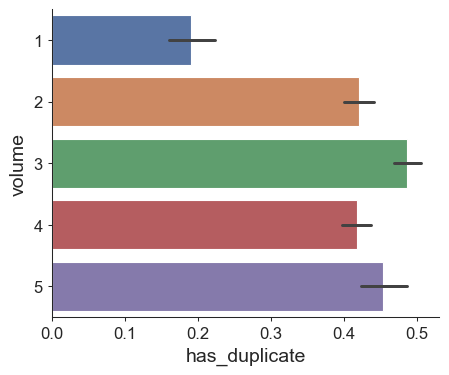

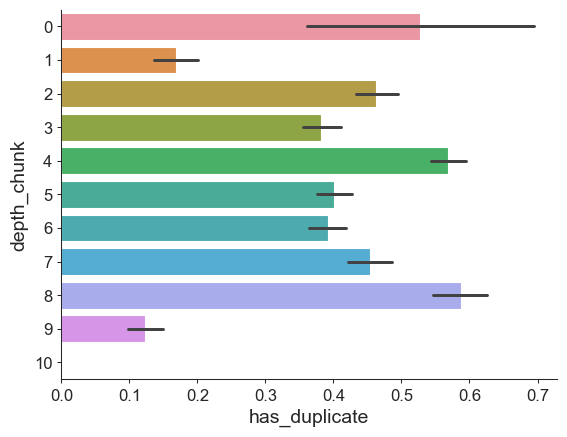

In [5]:
plt.figure(figsize=(5, 4))
sns.barplot(data=metrics_all[metrics_all.volume.isin([1, 2, 3, 4, 5])], y="volume", x="has_duplicate", orient="h")
plt.figure()
sns.barplot(data=metrics_all, y="depth_chunk", x="has_duplicate", orient="h")

<AxesSubplot: xlabel='n_duplicates', ylabel='count'>

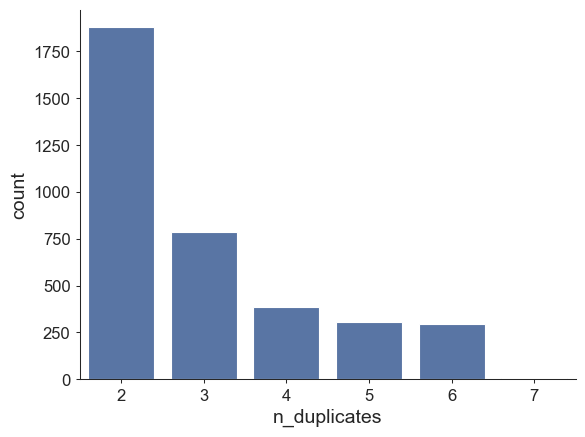

In [6]:
sns.countplot(data=metrics_all[metrics_all.has_duplicate], x="n_duplicates", color="b")

In [240]:
# Check ROIs with a lot of duplicates?
metrics_all[(metrics_all.n_duplicates == 6) & (metrics_all.dgw_frac_responsive_trials >= 0.5) & (metrics_all.dgf_frac_responsive_trials >= 0.5)].iloc[3].duplicate_rois

'M409828_12_1_215, M409828_12_2_101, M409828_12_4_149, M409828_12_5_246, M409828_12_6_151'

## Analyze DG metrics

In [245]:
n_tot = len(metrics) # same no. ROIs for both dg_full and dg_windowed
n_both = np.logical_and(metrics.dgf_is_responsive, metrics.dgw_is_responsive).value_counts()[True]
n_full = metrics.dgf_is_responsive.value_counts()[True]
n_windowed = metrics.dgw_is_responsive.value_counts()[True]
n_full_only = n_full - n_both
n_windowed_only = n_windowed - n_both
n_either = (metrics.dgf_is_responsive | metrics.dgw_is_responsive).value_counts()[True]
n_neither = np.logical_and(~metrics.dgf_is_responsive, ~metrics.dgw_is_responsive).value_counts()[True]

print(f"{n_full}/{n_tot} ({n_full/n_tot*100:.1f}%) ROIs are responsive to DG-full")
print(f"{n_windowed}/{n_tot} ({n_windowed/n_tot*100:.1f}%) ROIs are responsive to DG-windowed")
print()
print(f"{n_either}/{n_tot} ({n_either/n_tot*100:.1f}%) ROIs are responsive to DG-full OR DG-windowed")
print(f"{n_both}/{n_tot} ({n_both/n_tot*100:.1f}%) ROIs are responsive to BOTH DG-full AND DG-windowed")
print(f"{n_full_only}/{n_tot} ({n_full_only/n_tot*100:.1f}%) ROIs are responsive to ONLY DG-full")
print(f"{n_windowed_only}/{n_tot} ({n_windowed_only/n_tot*100:.1f}%) ROIs are responsive to ONLY DG-windowed")
print(f"{n_neither}/{n_tot} ({n_neither/n_tot*100:.1f}%) ROIs are responsive to NEITHER")

1779/7464 (23.8%) ROIs are responsive to DG-full
1531/7464 (20.5%) ROIs are responsive to DG-windowed

2693/7464 (36.1%) ROIs are responsive to DG-full OR DG-windowed
617/7464 (8.3%) ROIs are responsive to BOTH DG-full AND DG-windowed
1162/7464 (15.6%) ROIs are responsive to ONLY DG-full
914/7464 (12.2%) ROIs are responsive to ONLY DG-windowed
4771/7464 (63.9%) ROIs are responsive to NEITHER


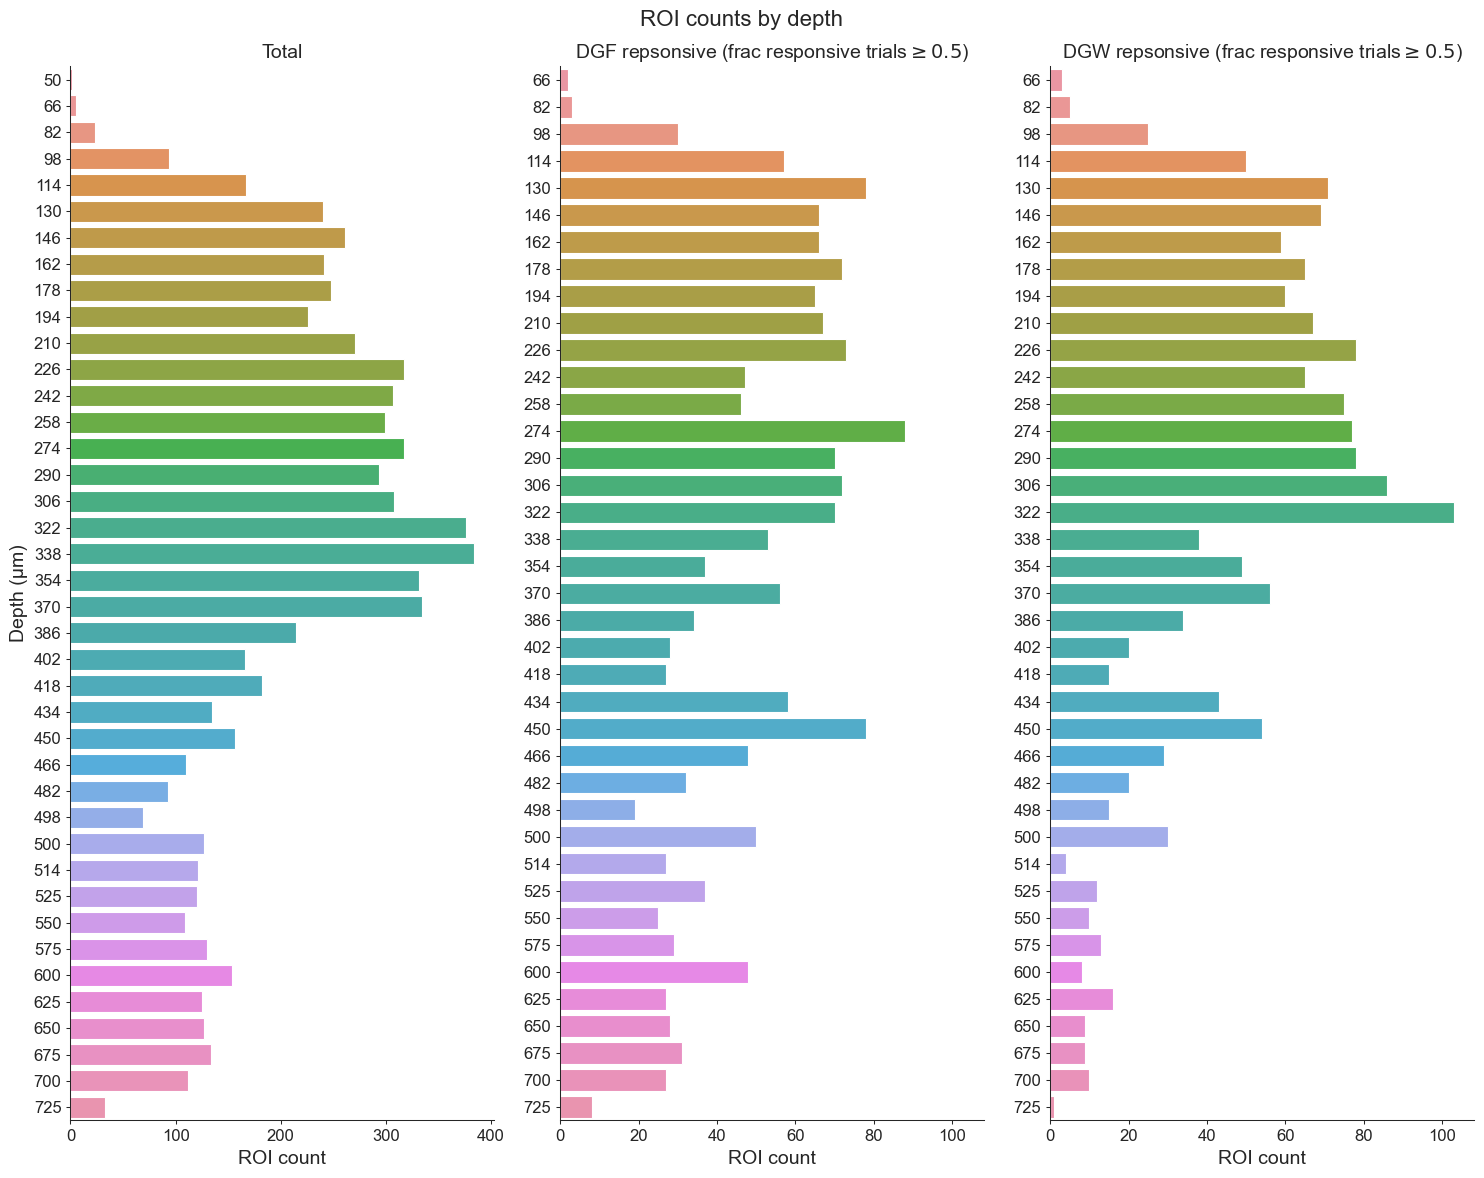

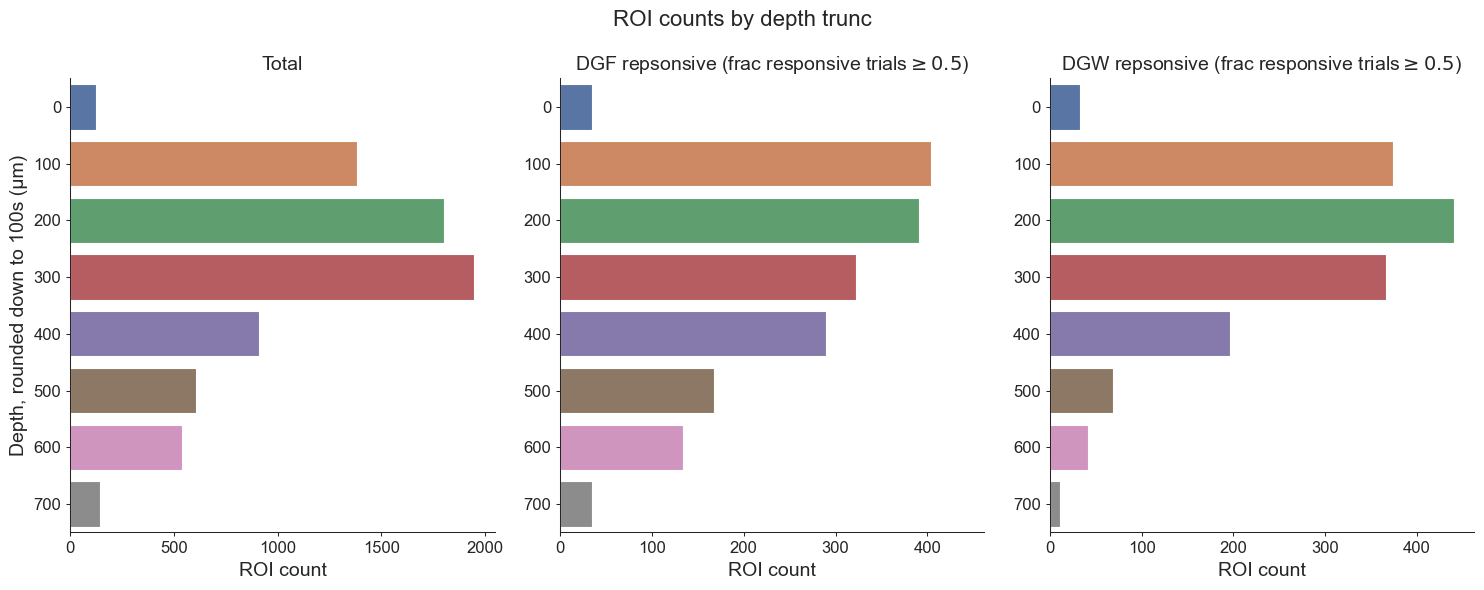

In [278]:
# Count by depth
fig, axs = plt.subplots(figsize=(15, 12), ncols=3)
sns.countplot(data=metrics, y="depth", orient="h", ax=axs[0])
sns.countplot(data=metrics[metrics.dgf_is_responsive], y="depth", orient="h", ax=axs[1])
sns.countplot(data=metrics[metrics.dgw_is_responsive], y="depth", orient="h", ax=axs[2])
plt.setp(axs[1:], xlim=(0, max(axs[1].get_xlim()[1], axs[2].get_xlim()[1])))
fig.suptitle("ROI counts by depth", fontsize=16)
axs[0].set_title("Total", fontsize=14)
axs[0].set_ylabel("Depth (µm)", fontsize=14)
axs[0].set_xlabel("ROI count", fontsize=14)
axs[1].set_title("DGF repsonsive (frac responsive trials$\geq 0.5$)", fontsize=14)
axs[1].set_xlabel("ROI count", fontsize=14)
axs[1].set_ylabel("")
axs[2].set_title("DGW repsonsive (frac responsive trials$\geq 0.5$)", fontsize=14)
axs[2].set_xlabel("ROI count", fontsize=14)
axs[2].set_ylabel("")
fig.tight_layout()

# Count by depth
fig, axs = plt.subplots(figsize=(15, 6), ncols=3)
sns.countplot(data=metrics, y="depth_trunc", orient="h", ax=axs[0])
sns.countplot(data=metrics[metrics.dgf_is_responsive], y="depth_trunc", orient="h", ax=axs[1])
sns.countplot(data=metrics[metrics.dgw_is_responsive], y="depth_trunc", orient="h", ax=axs[2])
plt.setp(axs[1:], xlim=(0, max(axs[1].get_xlim()[1], axs[2].get_xlim()[1])))
fig.suptitle("ROI counts by depth trunc", fontsize=16)
axs[0].set_title("Total", fontsize=14)
axs[0].set_ylabel("Depth, rounded down to 100s (µm)", fontsize=14)
axs[0].set_xlabel("ROI count", fontsize=14)
axs[1].set_title("DGF repsonsive (frac responsive trials$\geq 0.5$)", fontsize=14)
axs[1].set_xlabel("ROI count", fontsize=14)
axs[1].set_ylabel("")
axs[2].set_title("DGW repsonsive (frac responsive trials$\geq 0.5$)", fontsize=14)
axs[2].set_xlabel("ROI count", fontsize=14)
axs[2].set_ylabel("")
fig.tight_layout()

[0.0, 0.5, 0.0, 0.5]

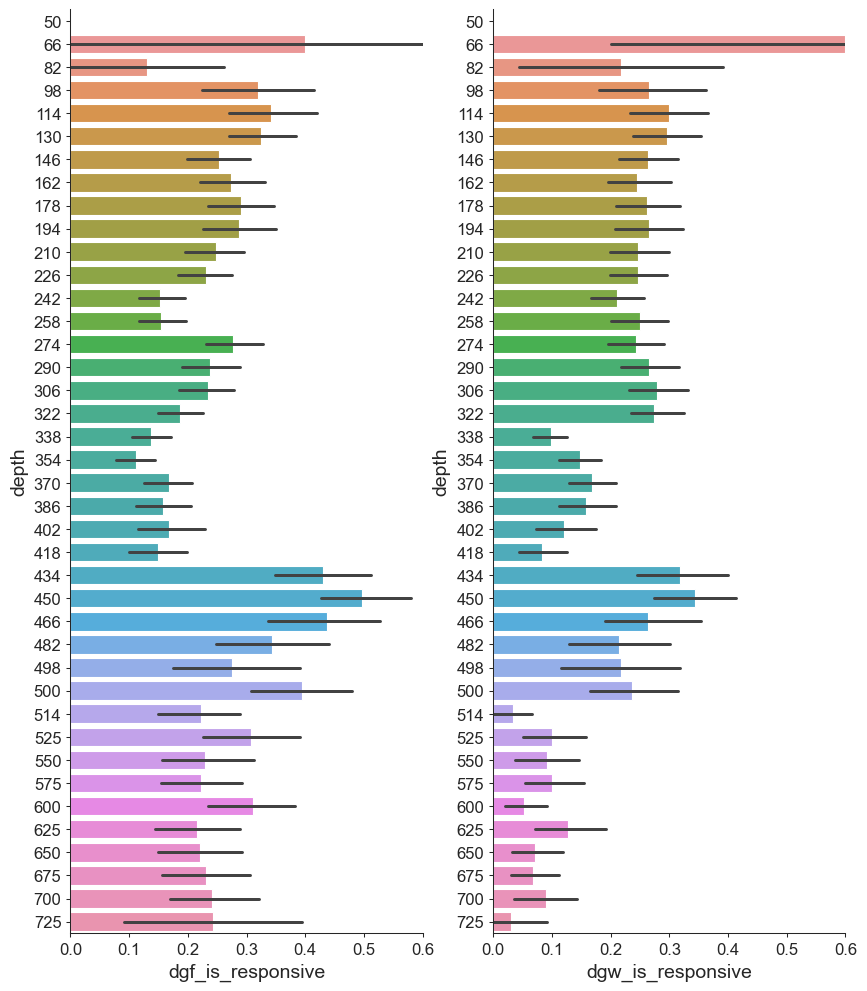

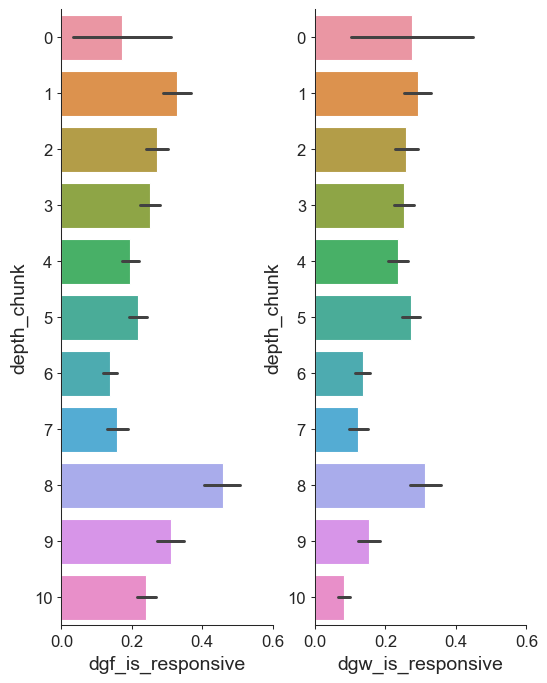

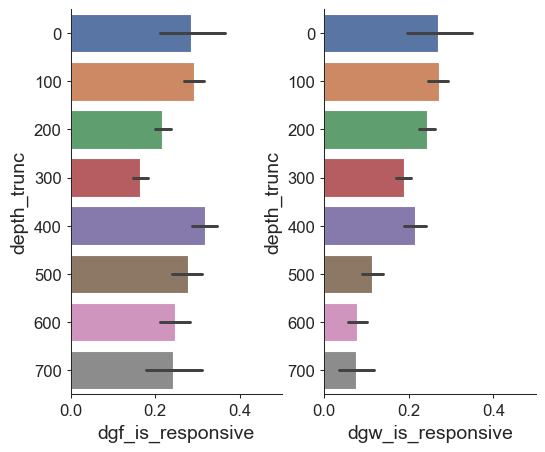

In [280]:
fig, axs = plt.subplots(figsize=(10, 12), ncols=2)
sns.barplot(data=metrics, y="depth", x="dgf_is_responsive", orient="h", ax=axs[0])
sns.barplot(data=metrics, y="depth", x="dgw_is_responsive", orient="h", ax=axs[1])
plt.setp(axs, xlim=(0, 0.6))

fig, axs = plt.subplots(figsize=(6, 8), ncols=2)
sns.barplot(data=metrics, y="depth_chunk", x="dgf_is_responsive", orient="h", ax=axs[0])
sns.barplot(data=metrics, y="depth_chunk", x="dgw_is_responsive", orient="h", ax=axs[1])
plt.setp(axs, xlim=(0, 0.6))

fig, axs = plt.subplots(figsize=(6, 5), ncols=2)
sns.barplot(data=metrics, y="depth_trunc", x="dgf_is_responsive", orient="h", ax=axs[0])
sns.barplot(data=metrics, y="depth_trunc", x="dgw_is_responsive", orient="h", ax=axs[1])
plt.setp(axs, xlim=(0, 0.5))

Compute tuning curve fits

In [101]:
from stimulus_analysis import fit_utils

metrics["ssi_fit"] = fit_utils.compute_dg_fit_ssi_from_metrics(metrics)
metrics["dgw_pref_dir_fit"] = fit_utils.get_dg_pref_dir(metrics, "dgw")
metrics["dgf_pref_dir_fit"] = fit_utils.get_dg_pref_dir(metrics, "dgf")
metrics["si_fit"] = fit_utils.compute_dg_fit_ssi_from_metrics(metrics, metric="si")

[0.0, 1.0, 0.0, 1.0]

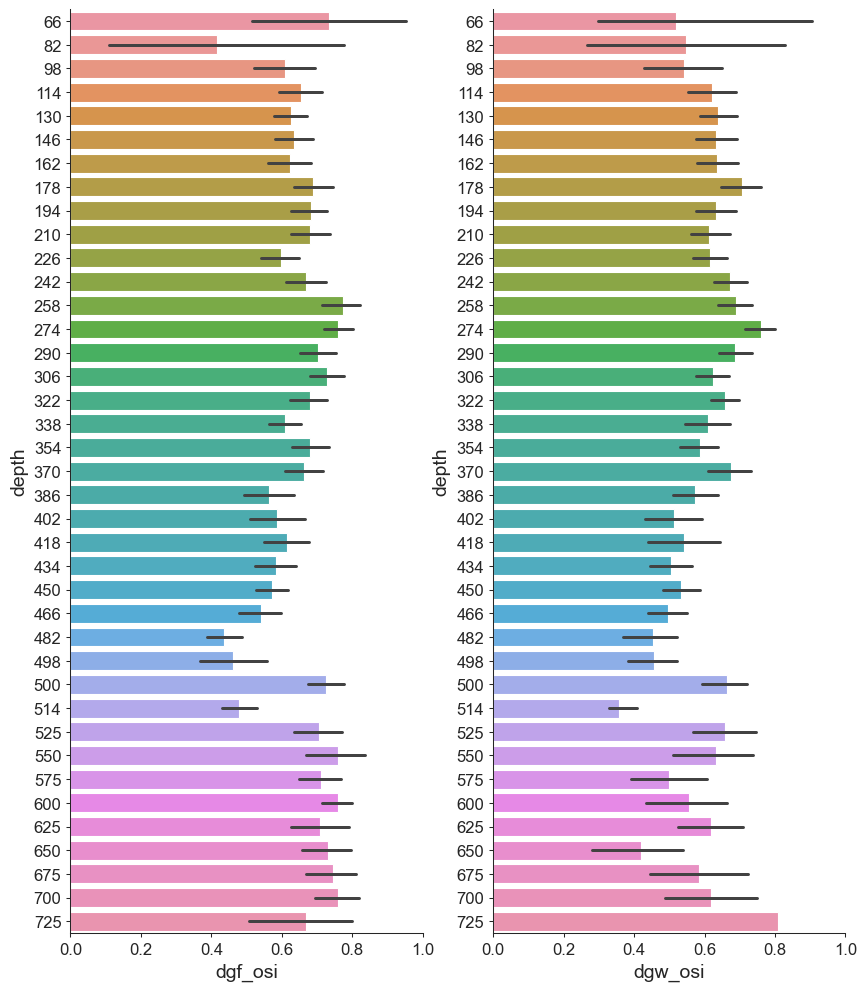

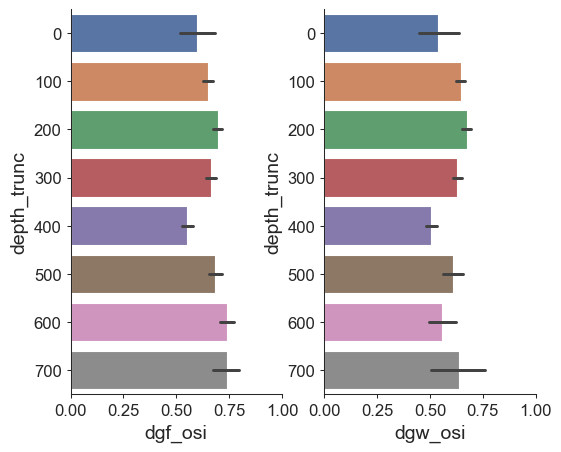

In [276]:
# OSI by depth
fig, axs = plt.subplots(figsize=(10, 12), ncols=2)
sns.barplot(data=metrics[metrics.dgf_is_responsive], y="depth", x="dgf_osi", orient="h", ax=axs[0])
sns.barplot(data=metrics[metrics.dgw_is_responsive], y="depth", x="dgw_osi", orient="h", ax=axs[1])
plt.setp(axs, xlim=(0, 1))

fig, axs = plt.subplots(figsize=(6, 5), ncols=2)
sns.barplot(data=metrics[metrics.dgf_is_responsive], y="depth_trunc", x="dgf_osi", orient="h", ax=axs[0])
sns.barplot(data=metrics[metrics.dgw_is_responsive], y="depth_trunc", x="dgw_osi", orient="h", ax=axs[1])
plt.setp(axs, xlim=(0, 1))

[0.0, 1.0, 0.0, 1.0]

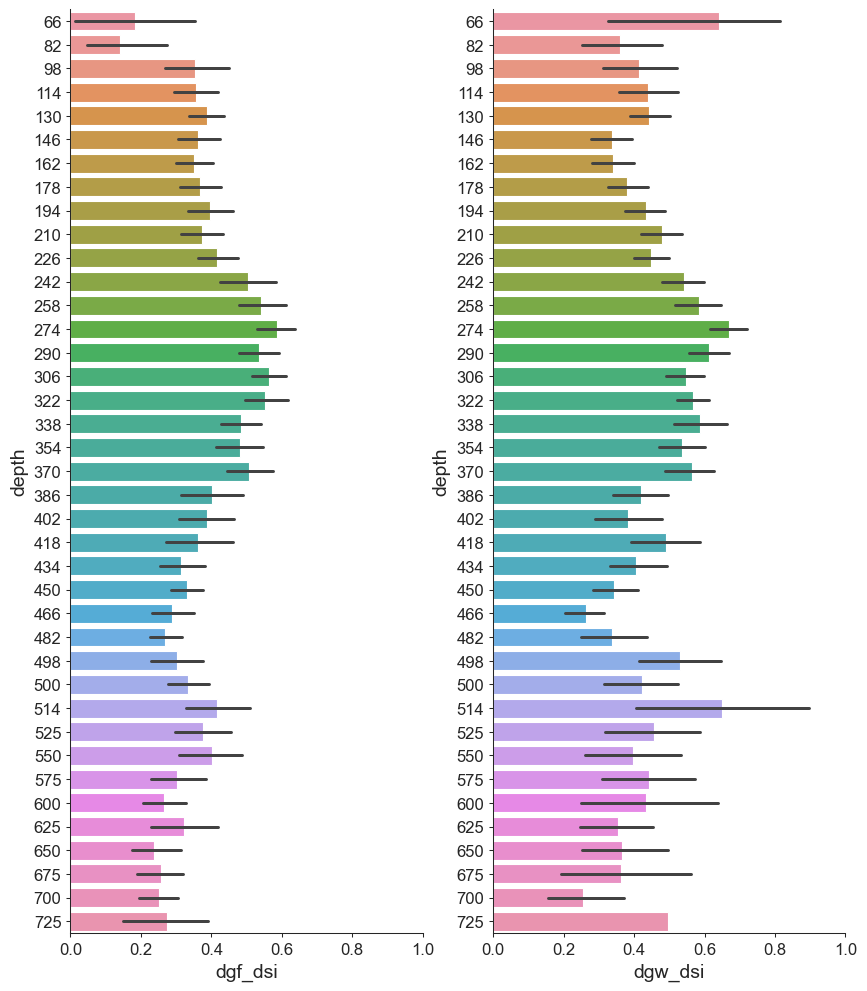

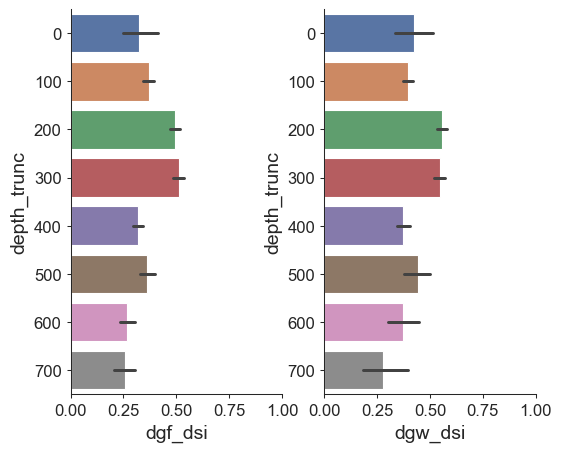

In [275]:
# DSI by depth
fig, axs = plt.subplots(figsize=(10, 12), ncols=2)
sns.barplot(data=metrics[metrics.dgf_is_responsive], y="depth", x="dgf_dsi", orient="h", ax=axs[0])
sns.barplot(data=metrics[metrics.dgw_is_responsive], y="depth", x="dgw_dsi", orient="h", ax=axs[1])
plt.setp(axs, xlim=(0, 1))

fig, axs = plt.subplots(figsize=(6, 5), ncols=2)
sns.barplot(data=metrics[metrics.dgf_is_responsive], y="depth_trunc", x="dgf_dsi", orient="h", ax=axs[0])
sns.barplot(data=metrics[metrics.dgw_is_responsive], y="depth_trunc", x="dgw_dsi", orient="h", ax=axs[1])
plt.setp(axs, xlim=(0, 1))

[0.0, 1.0, 0.0, 1.0]

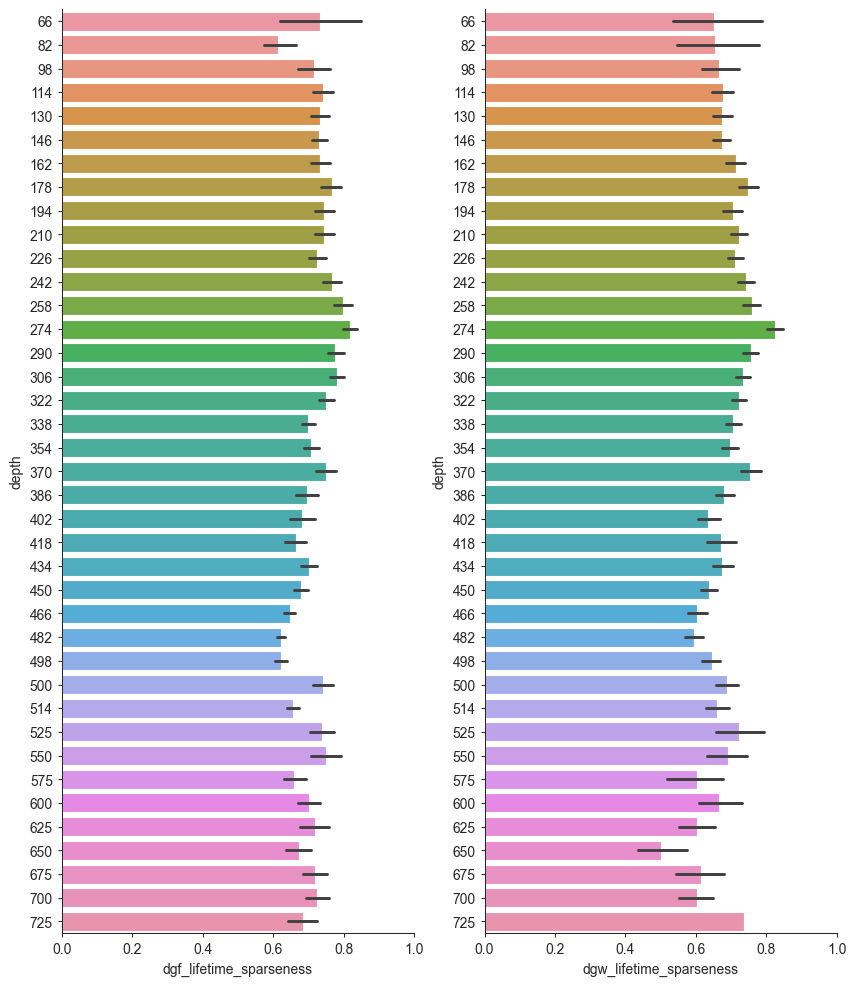

In [93]:
# OSI by depth
fig, axs = plt.subplots(figsize=(10, 12), ncols=2)
sns.barplot(data=metrics[metrics.dgf_is_responsive], y="depth", x="dgf_lifetime_sparseness", orient="h", ax=axs[0])
sns.barplot(data=metrics[metrics.dgw_is_responsive], y="depth", x="dgw_lifetime_sparseness", orient="h", ax=axs[1])
plt.setp(axs, xlim=(0, 1))

[0.0, 1.0, 0.0, 1.0]

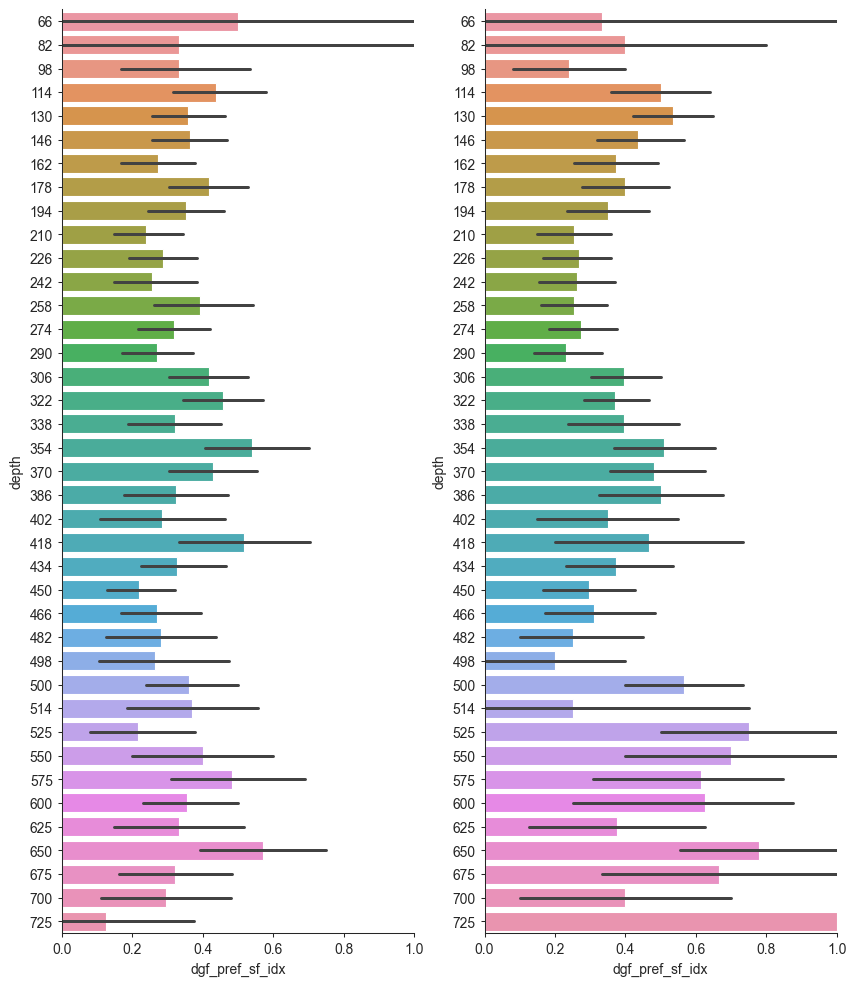

In [99]:
# OSI by depth
fig, axs = plt.subplots(figsize=(10, 12), ncols=2)
sns.barplot(data=metrics[metrics.dgf_is_responsive], y="depth", x="dgf_pref_sf_idx", orient="h", ax=axs[0])
sns.barplot(data=metrics[metrics.dgw_is_responsive], y="depth", x="dgf_pref_sf_idx", orient="h", ax=axs[1])
plt.setp(axs, xlim=(0, 1))

<AxesSubplot: xlabel='dgf_pref_dir', ylabel='count'>

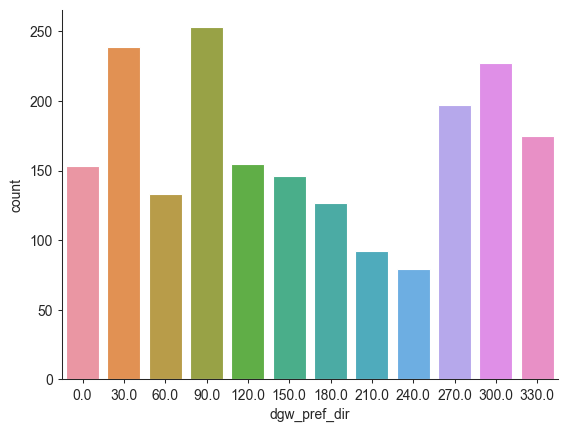

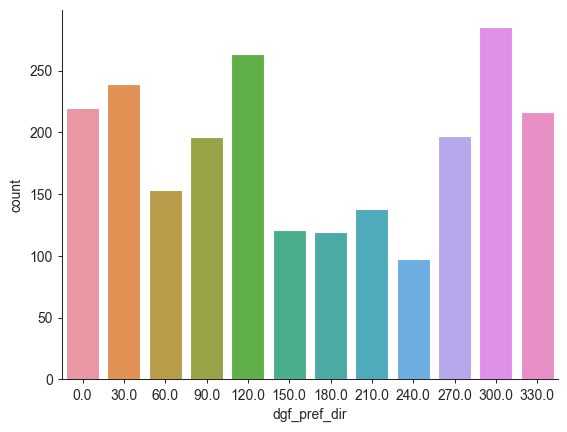

In [41]:
sns.countplot(data=metrics[metrics.dgw_is_responsive], x="dgw_pref_dir")
plt.figure()
sns.countplot(data=metrics[metrics.dgf_is_responsive], x="dgf_pref_dir")

In [232]:
metrics.index[metrics.dgw_is_responsive & metrics.dgf_is_responsive & (metrics.ssi_fit > 0.9) & (metrics.ssi < -0.6)]

Index(['M409828_13_5_153'], dtype='object')

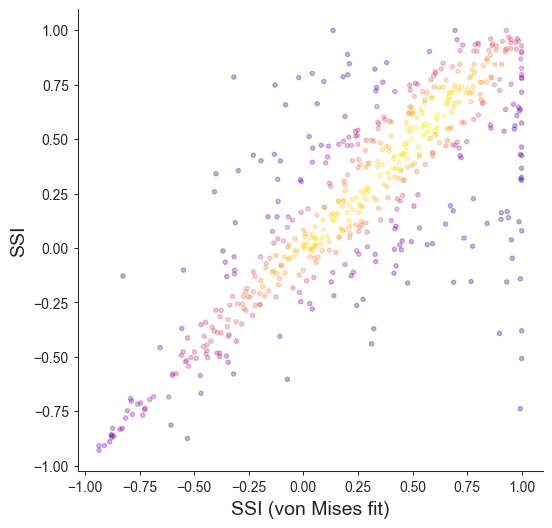

In [229]:
inclusion = metrics.dgw_is_responsive & metrics.dgf_is_responsive
at.density_scatter(
    metrics.ssi_fit[inclusion], metrics.ssi[inclusion],
    figsize=(6, 6),
    xlabel="SSI (von Mises fit)",
    ylabel="SSI",
    alpha=0.3,
    s=10
).axis("equal")
None # no ipynb output

(-17.999999999999996,
 377.99999999999994,
 -17.999999999999996,
 377.99999999999994)

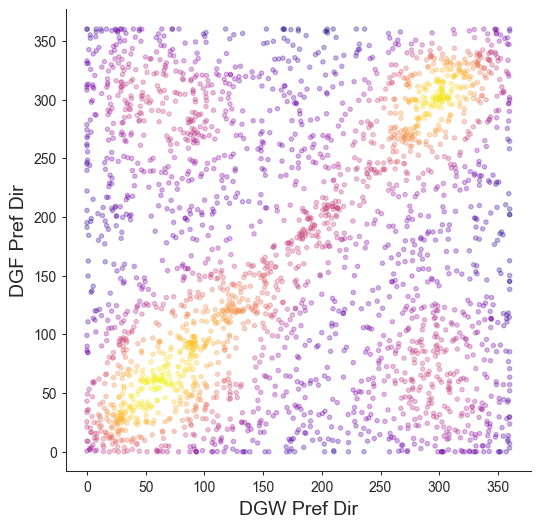

In [36]:
inclusion = metrics.dgw_is_responsive | metrics.dgf_is_responsive
at.density_scatter(
    metrics.dgw_pref_dir_fit[inclusion], metrics.dgf_pref_dir_fit[inclusion],
    figsize=(6, 6),
    xlabel="DGW Pref Dir",
    ylabel="DGF Pref Dir",
    alpha=0.3,
    s=10
).axis("equal")

Text(0.5, 1.0, 'Differences in preferred direction for ROIs responsive to both DGW and DGF')

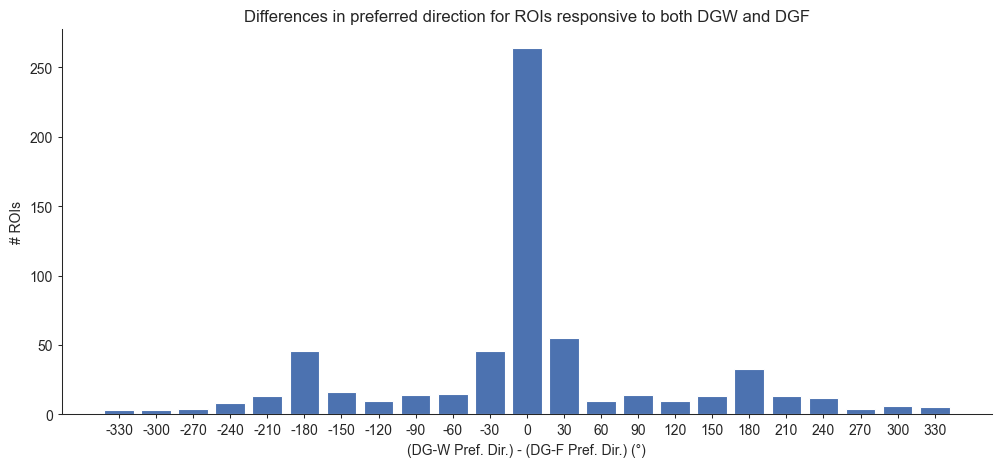

In [87]:
# Histogram of delta dir pref. across ROIs
plt.figure(figsize=(12, 5))
roi_delta_dir = (metrics["dgw_pref_dir"] - metrics["dgf_pref_dir"])[metrics.dgw_is_responsive & metrics.dgf_is_responsive].values

delta_dir = sorted(np.unique(roi_delta_dir))
counts = [np.count_nonzero(roi_delta_dir == x) for x in delta_dir]
plt.bar([f"{d:.0f}" for d in delta_dir], counts)
plt.xlabel("(DG-W Pref. Dir.) - (DG-F Pref. Dir.) (°)")
plt.ylabel("# ROIs")
plt.title("Differences in preferred direction for ROIs responsive to both DGW and DGF")

  0%|          | 0/6 [00:00<?, ?it/s]

[0.0, 0.3, 0.0, 0.3, 0.0, 0.3, 0.0, 0.3, 0.0, 0.3, 0.0, 0.3]

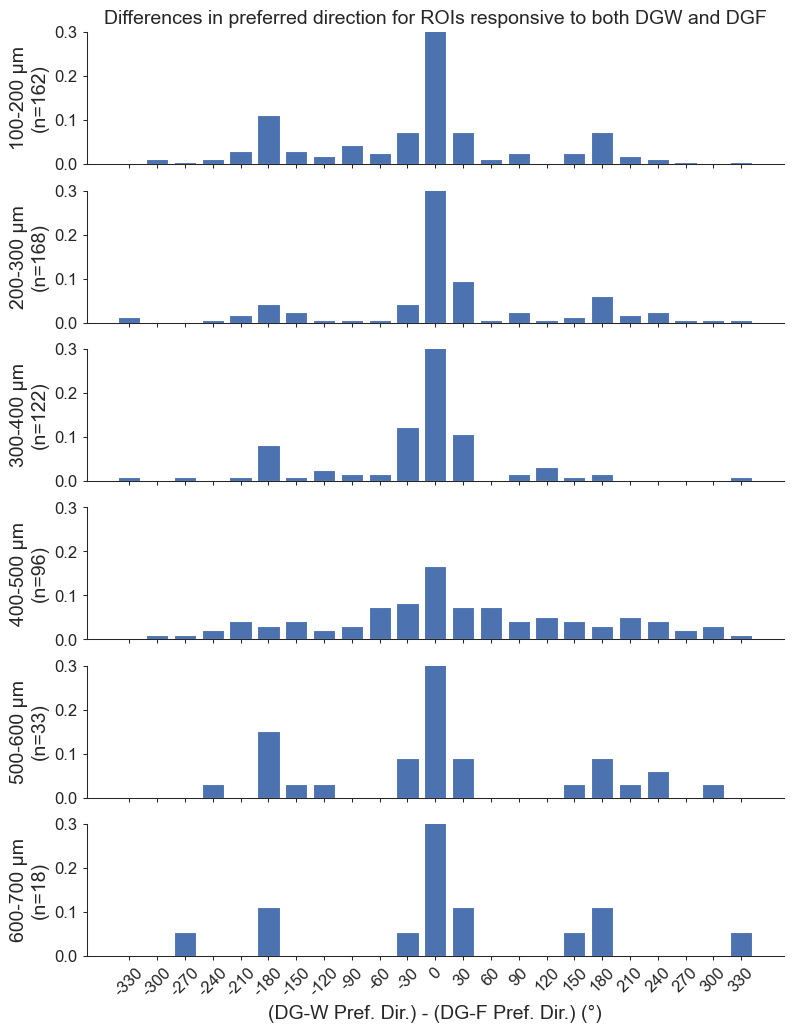

In [274]:
# Histogram of delta dir pref. across ROIs
relative_dir = np.arange(-180, 181)
depth_chunks = metrics.depth_trunc.unique()[1:-1] # first and last don't have many ROIs
fig, axs = plt.subplots(figsize=(9, 2*len(depth_chunks)), nrows=len(depth_chunks))
delta_dir = np.arange(-330, 340, 30)

for plot_i, (depth_chunk, ax) in tqdm(enumerate(zip(depth_chunks, axs)), total=len(depth_chunks)):
    metrics_mask = (metrics.depth_trunc == depth_chunk) & (metrics.dgw_frac_responsive_trials >= 0.5) & (metrics.dgf_frac_responsive_trials >= 0.5)
    roi_delta_dir = (metrics["dgw_pref_dir"] - metrics["dgf_pref_dir"]).values[metrics_mask]
    n_rois = int(metrics_mask.sum())
    counts = np.array([np.count_nonzero(roi_delta_dir == x) for x in delta_dir])
    counts = counts / n_rois
    ax.bar([f"{d:.0f}" for d in delta_dir], counts)    
    ax.set_ylabel(f"{depth_chunk}-{depth_chunk+100} µm\n(n={n_rois})")

    if plot_i == 0:
        ax.set_title("Differences in preferred direction for ROIs responsive to both DGW and DGF")
    if plot_i == len(axs)-1:
        ax.set_xlabel("(DG-W Pref. Dir.) - (DG-F Pref. Dir.) (°)")
        plt.setp(ax.get_xticklabels(), rotation=45)
    else:
        ax.set_xticklabels([])

plt.setp(axs, ylim=(0, 0.3))

## Analyze SSI

In [39]:
# Include SSI for ROIs that are responsive to DGW
ssi_inclusion = metrics.dgw_is_responsive

(-1.0, 1.0)

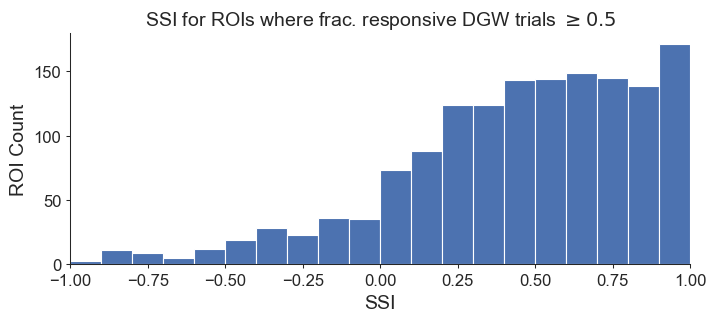

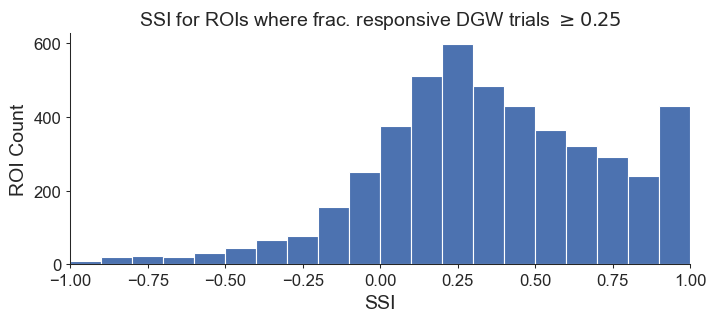

In [251]:
plt.figure(figsize=(8, 3))
plt.hist(metrics.ssi_fit[metrics.dgw_frac_responsive_trials >= 0.5], bins=np.arange(-1, 1.1, 0.1))
plt.title("SSI for ROIs where frac. responsive DGW trials $\geq 0.5$")
plt.xlabel("SSI")
plt.ylabel("ROI Count")
plt.xlim(-1, 1)


plt.figure(figsize=(8, 3))
plt.hist(metrics.ssi_fit[metrics.dgw_frac_responsive_trials >= 0.25], bins=np.arange(-1, 1.1, 0.1))
plt.title("SSI for ROIs where frac. responsive DGW trials $\geq 0.25$")
plt.xlabel("SSI")
plt.ylabel("ROI Count")
plt.xlim(-1, 1)

# plt.figure(figsize=(4, 3))
# plt.hist(metrics.si_fit[metrics.dgw_frac_responsive_trials >= 0.5], bins=np.arange(0, 1.1, 0.1))
# plt.title("*SI* for ROIs where frac. responsive DGW trials $\geq 0.5$")
# plt.xlabel("*SI*")
# plt.ylabel("ROI Count")
# plt.xlim(0, 1)

<AxesSubplot: xlabel='ssi_fit', ylabel='depth_chunk'>

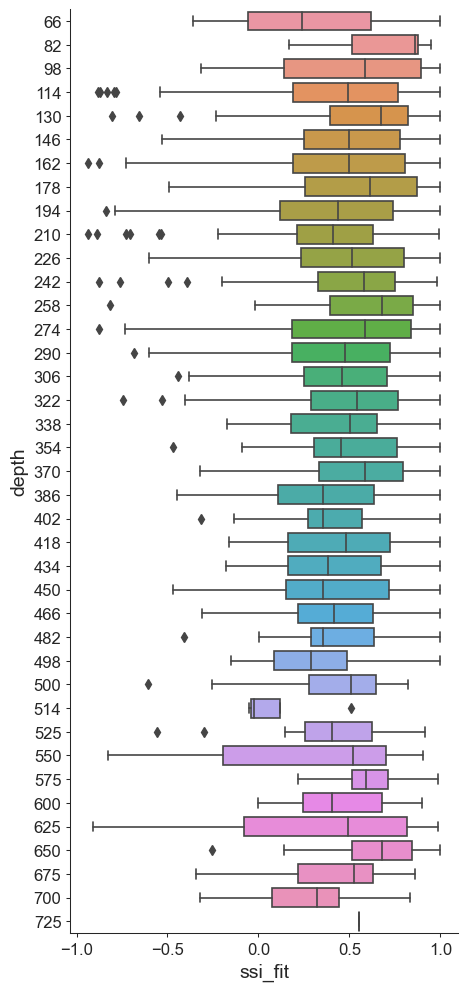

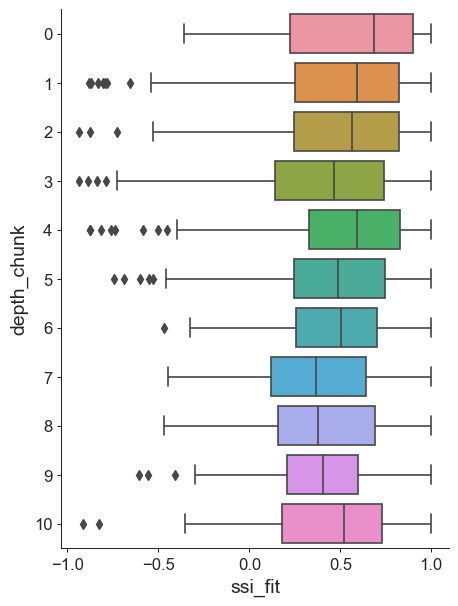

In [252]:
# SSI by depth
plt.figure(figsize=(5, 12))
sns.boxplot(data=metrics[ssi_inclusion], y="depth", x="ssi_fit", orient="h")

plt.figure(figsize=(5, 7))
sns.boxplot(data=metrics[ssi_inclusion], y="depth_chunk", x="ssi_fit", orient="h")

<AxesSubplot: xlabel='ssi', ylabel='depth_chunk'>

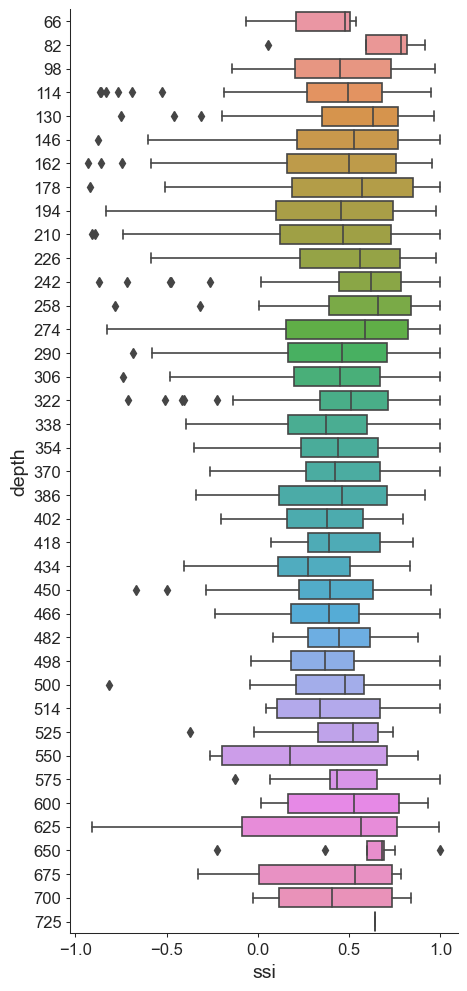

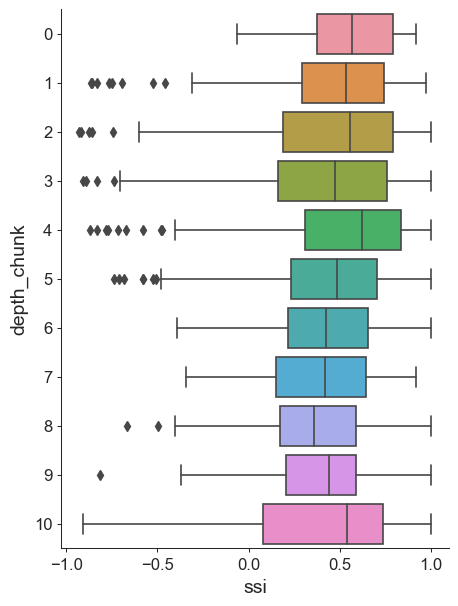

In [253]:
# SSI (using mean responses) by depth
plt.figure(figsize=(5, 12))
sns.boxplot(data=metrics[ssi_inclusion], y="depth", x="ssi", orient="h")

plt.figure(figsize=(5, 7))
sns.boxplot(data=metrics[ssi_inclusion], y="depth_chunk", x="ssi", orient="h")

## Analyze surround suppression for different orientations

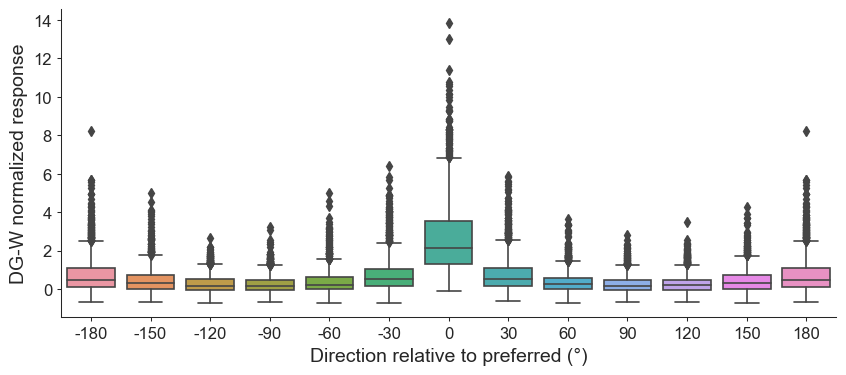

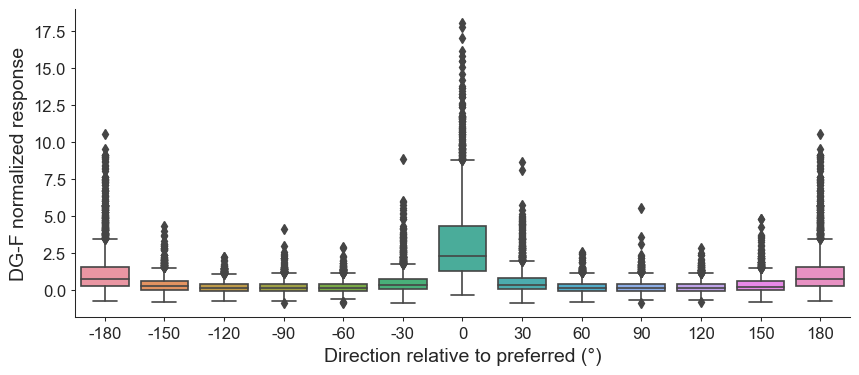

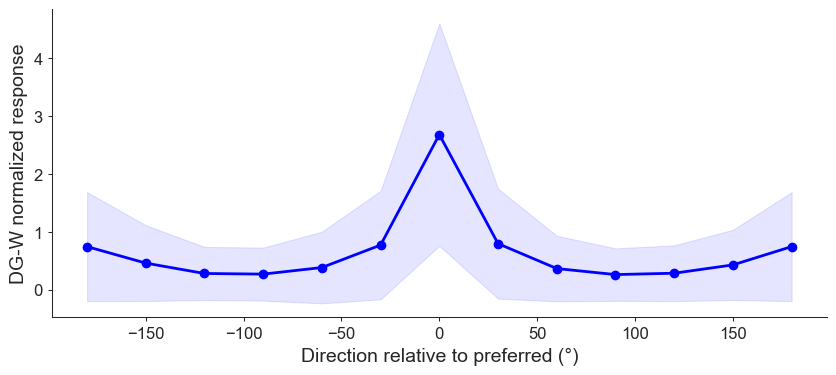

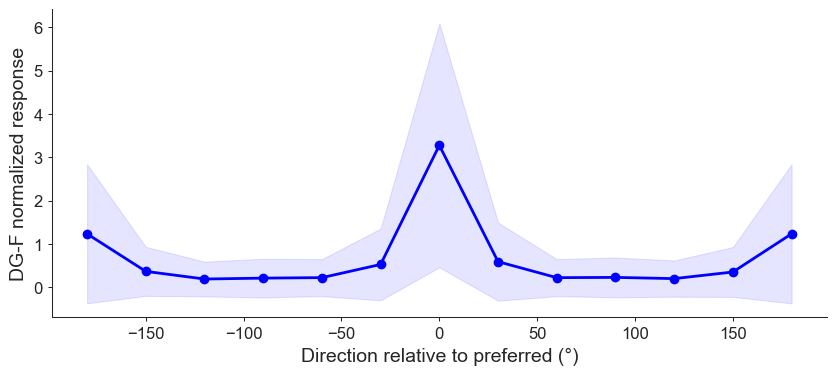

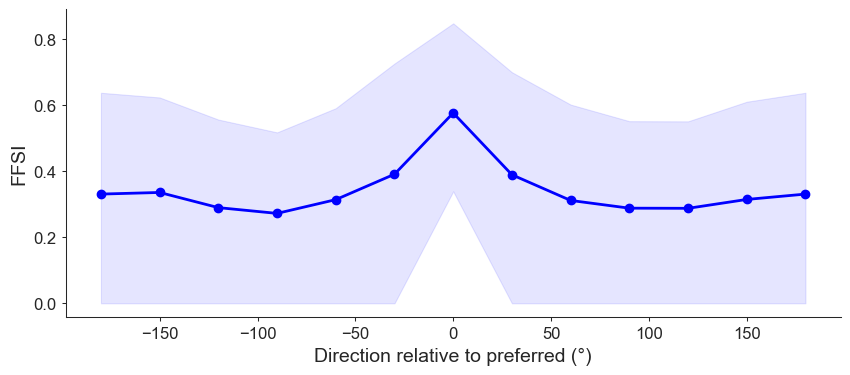

In [122]:
relative_dir_list = np.array([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
relative_dir_idx = np.arange(13) - 6
ffsi_by_rel_dir = [[] for _ in relative_dir_idx]
dgw_norm_resp_by_rel_dir = [[] for _ in relative_dir_idx]
dgf_norm_resp_by_rel_dir = [[] for _ in relative_dir_idx]

for i, row in metrics.iterrows():
    if not row["is_valid"]:
        break
    
    if row["dgw_frac_responsive_trials"] >= 0.5:
        pref_dir_idx = int(row["dgw_pref_dir_idx"])
        ffsi_all_dirs = eval(row["ffsi_all_dirs"])
        dgw_norm_dir_responses = eval(row["dgw_norm_dir_responses"])

        for j, dir_offset in enumerate(relative_dir_idx):
            dir_i = (pref_dir_idx+dir_offset) % 12
            ffsi = ffsi_all_dirs[dir_i]
            ffsi = max(0, ffsi)
            ffsi_by_rel_dir[j].append(ffsi)
            dgw_norm_resp_by_rel_dir[j].append(dgw_norm_dir_responses[dir_i])

    if row["dgf_frac_responsive_trials"] >= 0.5:
        pref_dir_idx = int(row["dgf_pref_dir_idx"])
        dgf_norm_dir_responses = eval(row["dgf_norm_dir_responses"])

        for j, dir_offset in enumerate(relative_dir_idx):
            dir_i = (pref_dir_idx+dir_offset) % 12
            dgf_norm_resp_by_rel_dir[j].append(dgf_norm_dir_responses[dir_i])

# Norm resp. box plot
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
x, y = [], []
for dir, arr in zip(relative_dir_list, dgw_norm_resp_by_rel_dir):
    x.extend([dir] * len(arr))
    y.extend(arr)
sns.boxplot(x=x, y=y, ax=ax)
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("DG-W normalized response", fontsize=14)

fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
x, y = [], []
for dir, arr in zip(relative_dir_list, dgf_norm_resp_by_rel_dir):
    x.extend([dir] * len(arr))
    y.extend(arr)
sns.boxplot(x=x, y=y, ax=ax)
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("DG-F normalized response", fontsize=14)
# ax.set_ylim(-5, 50)

# Line plot of means ± error
y_means = np.array([np.mean(arr) for arr in dgw_norm_resp_by_rel_dir])
y_err = np.array([np.std(arr) for arr in dgw_norm_resp_by_rel_dir])
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("DG-W normalized response", fontsize=14)
# plt.errorbar(relative_dir_list, y_means, yerr=y_err)
ax.plot(relative_dir_list, y_means, color="blue", linewidth=2, marker=".", markersize=12)
ax.fill_between(relative_dir_list, y_means-y_err, y_means+y_err, color="blue", alpha=0.1)

y_means = np.array([np.mean(arr) for arr in dgf_norm_resp_by_rel_dir])
y_err = np.array([np.std(arr) for arr in dgf_norm_resp_by_rel_dir])
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("DG-F normalized response", fontsize=14)
# plt.errorbar(relative_dir_list, y_means, yerr=y_err)
ax.plot(relative_dir_list, y_means, color="blue", linewidth=2, marker=".", markersize=12)
ax.fill_between(relative_dir_list, y_means-y_err, y_means+y_err, color="blue", alpha=0.1)

# FFSI line plot
y_ffsi_means = np.array([np.mean(arr) for arr in ffsi_by_rel_dir])
y_ffsi_err = np.array([np.std(arr) for arr in ffsi_by_rel_dir])
y_ffsi_err_low = [np.quantile(arr, 0.25) for arr in ffsi_by_rel_dir]
y_ffsi_err_high = [np.quantile(arr, 0.75) for arr in ffsi_by_rel_dir]
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("FFSI", fontsize=14)
# plt.errorbar(relative_dir_list, y_means, yerr=y_err)
ax.plot(relative_dir_list, y_ffsi_means, color="blue", linewidth=2, marker=".", markersize=12)
# ax.fill_between(relative_dir_list, y_ffsi_means-y_ffsi_err, y_ffsi_means+y_ffsi_err, color="blue", alpha=0.1)
ax.fill_between(relative_dir_list, y_ffsi_err_low, y_ffsi_err_high, color="blue", alpha=0.1)

In [128]:
metrics.dgw_pref_dir

M409828_11_1_89      0.0
M409828_11_2_0       0.0
M409828_11_2_1      30.0
M409828_11_2_2      30.0
M409828_11_2_4     330.0
                   ...  
M409828_1f_1_67    240.0
M409828_1f_1_69    120.0
M409828_1f_1_70     60.0
M409828_1f_1_74    180.0
M409828_1f_1_90    210.0
Name: dgw_pref_dir, Length: 7464, dtype: float64

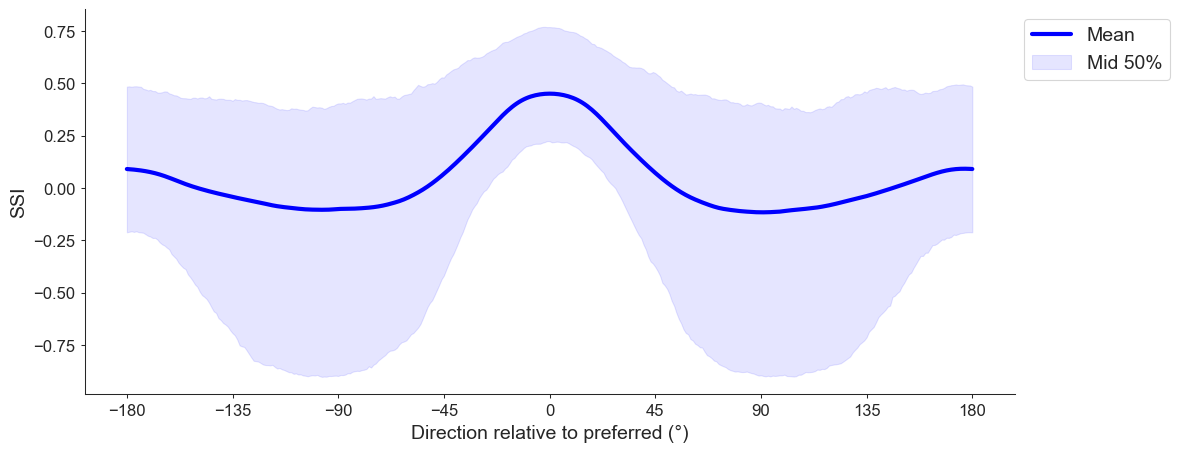

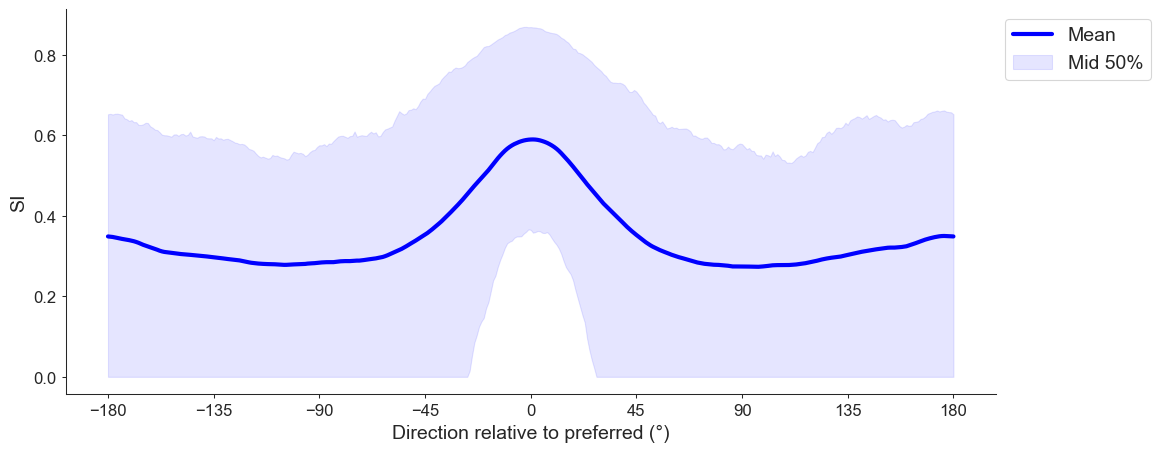

In [179]:
relative_dir = np.arange(-180, 181)
ssi_by_rel_dir = [[] for _ in relative_dir]
si_by_rel_dir = [[] for _ in relative_dir]

for _, row in metrics.iterrows():
    if row["dgw_frac_responsive_trials"] >= 0.5:
        # DGW responsive
        dgw_pref_sf_idx = int(row["dgw_pref_sf_idx"])
        dgw_tuning_pref_dir = row[f"dgw_vonmises_{dgw_pref_sf_idx}_pref_dir"]
        
        # Ignore when fit is bad
        if pd.isna(dgw_tuning_pref_dir) or pd.isna(row[f"dgf_vonmises_{dgw_pref_sf_idx}_pref_dir"]):
            continue

        dgw_tuning_pref_dir = int(dgw_tuning_pref_dir)
        dgw_tuning_params = [row[f"dgw_vonmises_{dgw_pref_sf_idx}_param_{i}"] for i in range(6)]
        dgf_tuning_params = [row[f"dgf_vonmises_{dgw_pref_sf_idx}_param_{i}"] for i in range(6)]
        dgf_tuning_amp_at_dgw_pref_dir = fit_utils.vonmises_two_peak_get_amplitude(dgw_tuning_pref_dir, dgf_tuning_params)

        for i, deg_offset in enumerate(relative_dir):
            x = (dgw_tuning_pref_dir + deg_offset) % 360
            dgw_amp = fit_utils.vonmises_two_peak_get_amplitude(x, params=dgw_tuning_params)
            dgf_amp = fit_utils.vonmises_two_peak_get_amplitude(x, params=dgf_tuning_params)
            ssi = 0 if (dgw_amp + dgf_amp) == 0 else (dgw_amp - dgf_amp) / (dgw_amp + dgf_amp)
            si = 0 if dgw_amp == dgf_amp else 1 - dgf_amp / max(dgw_amp, dgf_amp)
            ssi_by_rel_dir[i].append(ssi)
            si_by_rel_dir[i].append(si)

for data, metric_name in ((ssi_by_rel_dir, "SSI"), (si_by_rel_dir, "SI")):
    data = np.array(data)
    fig, ax = plt.subplots(figsize=(12, 5))
    y_mean = np.mean(data, axis=1)
    # y_err = np.std(data, axis=1)
    # y_err_low, y_err_high = y_mean - y_err, y_mean + y_err
    y_err_low, y_err_high = np.quantile(data, q=(0.25, 0.75), axis=1)
    ax.tick_params(labelsize=12)
    ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
    ax.set_ylabel(metric_name, fontsize=14)
    ax.plot(relative_dir, y_mean, color="blue", linewidth=3, label="Mean")
    ax.fill_between(relative_dir, y_err_low, y_err_high, color="blue", alpha=0.1, label="Mid 50%")
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.legend(loc="upper left", fontsize=14, bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)


  0%|          | 0/6 [00:00<?, ?it/s]

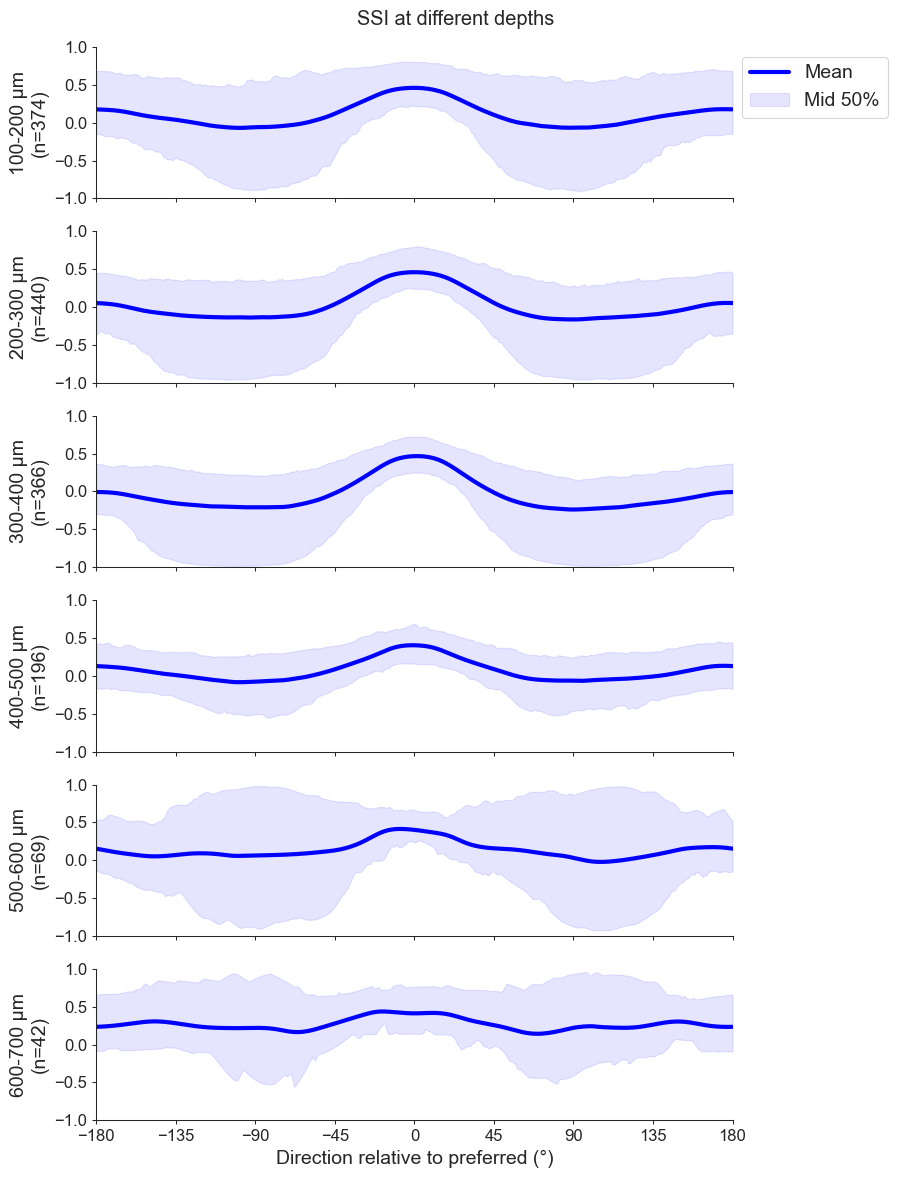

In [258]:
relative_dir = np.arange(-180, 181)
depth_chunks = metrics.depth_trunc.unique()[1:-1] # first and last don't have many
fig, axs = plt.subplots(figsize=(9, 2*len(depth_chunks)), nrows=len(depth_chunks))

for plot_i, (depth_chunk, ax) in tqdm(enumerate(zip(depth_chunks, axs)), total=len(depth_chunks)):
    metrics_mask = (metrics.depth_trunc == depth_chunk) & (metrics.dgw_frac_responsive_trials >= 0.5)
    # metrics_mask = (metrics.depth_trunc == depth_chunk) & (metrics.dgw_frac_responsive_trials >= 0.5) & (metrics.dgw_dsi >= 0.5)
    ssi_by_rel_dir = [[] for _ in relative_dir]
    si_by_rel_dir = [[] for _ in relative_dir]

    for _, row in metrics[metrics_mask].iterrows():
        dgw_pref_sf_idx = int(row["dgw_pref_sf_idx"])
        dgw_tuning_pref_dir = row[f"dgw_vonmises_{dgw_pref_sf_idx}_pref_dir"]
        
        # Ignore when fit is bad
        if pd.isna(dgw_tuning_pref_dir) or pd.isna(row[f"dgf_vonmises_{dgw_pref_sf_idx}_pref_dir"]):
            continue

        dgw_tuning_pref_dir = int(dgw_tuning_pref_dir)
        dgw_tuning_params = [row[f"dgw_vonmises_{dgw_pref_sf_idx}_param_{i}"] for i in range(6)]
        dgf_tuning_params = [row[f"dgf_vonmises_{dgw_pref_sf_idx}_param_{i}"] for i in range(6)]
        dgf_tuning_amp_at_dgw_pref_dir = fit_utils.vonmises_two_peak_get_amplitude(dgw_tuning_pref_dir, dgf_tuning_params)

        for i, deg_offset in enumerate(relative_dir):
            x = (dgw_tuning_pref_dir + deg_offset) % 360
            dgw_amp = fit_utils.vonmises_two_peak_get_amplitude(x, params=dgw_tuning_params)
            dgf_amp = fit_utils.vonmises_two_peak_get_amplitude(x, params=dgf_tuning_params)
            ssi = 0 if (dgw_amp + dgf_amp) == 0 else (dgw_amp - dgf_amp) / (dgw_amp + dgf_amp)
            si = 0 if dgw_amp == dgf_amp else 1 - dgf_amp / max(dgw_amp, dgf_amp)
            ssi_by_rel_dir[i].append(ssi)
            si_by_rel_dir[i].append(si)

    ax.set_ylabel(f"{depth_chunk}-{depth_chunk+100} µm\n(n={metrics_mask.sum()})")

    # for data, metric_name in ((ssi_by_rel_dir, "SSI"), (si_by_rel_dir, "SI")):
    # for data, metric_name in ((si_by_rel_dir, "SI"),):
    for data, metric_name in ((ssi_by_rel_dir, "SSI"),):
        data = np.array(data)
        y_mean = np.mean(data, axis=1)
        # y_err = np.std(data, axis=1)
        # y_err_low, y_err_high = y_mean - y_err, y_mean + y_err
        y_err_low, y_err_high = np.quantile(data, q=(0.25, 0.75), axis=1)

        ax.plot(relative_dir, y_mean, color="blue", linewidth=3, label="Mean")
        ax.fill_between(relative_dir, y_err_low, y_err_high, color="blue", alpha=0.1, label="Mid 50%")
        ax.tick_params(labelsize=12)
        ax.set_xticks([])
        ax.set_xlim(-180, 180)
        ax.set_ylim(-1, 1)
        ax.set_xticks(np.arange(-180, 181, 45))

        if plot_i == 0:
            ax.legend(loc="upper left", fontsize=14, bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
        
        if plot_i == len(depth_chunks) - 1:
            ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
        else:
            ax.set_xticklabels([])

fig.suptitle("SSI at different depths")
fig.tight_layout()

## Check brain observatory metrics

In [202]:
brain_obs_metrics = pd.read_csv("/Users/chase/Desktop/MindScope/Documents/visual-coding-saccades/data/metrics.csv", low_memory=False)
brain_obs_metrics.head()

# 

/var/folders/8l/944wpj6s7sq8gcv57wcd3q6h0000gn/T/ipykernel_36700/2172234248.py:1: DtypeWarning: Columns (4,8,12,16,20,32,53,69) have mixed types. Specify dtype option on import or set low_memory=False.
  brain_obs_metrics = pd.read_csv("/Users/chase/Desktop/MindScope/Documents/visual-coding-saccades/data/metrics.csv")


,Unnamed: 0.1,Unnamed: 0,cell_specimen_id,lifetime_sparseness_nm3,responsive_nm3,reliability_nm3,peak_frame_nm3,lifetime_sparseness_nm1a,responsive_nm1a,reliability_nm1a,...,responsive_nmall,run_stat_dg,responsive_rundg,run_corr_mean,run_corr_A_lw,run_corr_B_lw,run_corr_C_lw,responsive_run,dg_all_RidgeRegress_CC,cluster_id
0,0,0,570928778,0.979543,False,0.014272,1026.0,0.967212,False,0.016819,...,True,NaN,False,NaN,-0.001078,-0.018117,0.039354,False,0.083038,NaN
1,1,1,570928986,0.967574,False,0.011196,361.0,0.978374,True,0.344332,...,True,-0.551957,False,NaN,0.001142,0.078896,NaN,False,0.278657,NaN
2,2,2,570929244,0.972431,False,0.019493,804.0,0.970074,False,0.016020,...,True,NaN,False,NaN,0.016949,0.113203,NaN,False,0.257520,NaN
3,3,3,570929249,0.984766,False,0.011741,696.0,0.993494,True,0.213434,...,True,NaN,False,NaN,0.004977,0.067388,NaN,False,0.294201,NaN
4,4,4,570928981,0.968906,True,0.046999,161.0,0.961156,False,0.024980,...,True,2.937988,False,NaN,0.066659,NaN,NaN,False,0.407533,NaN


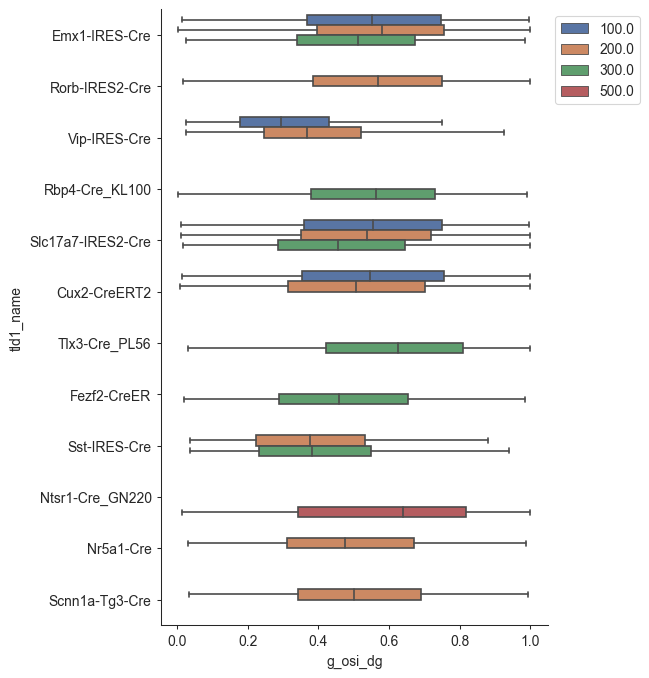

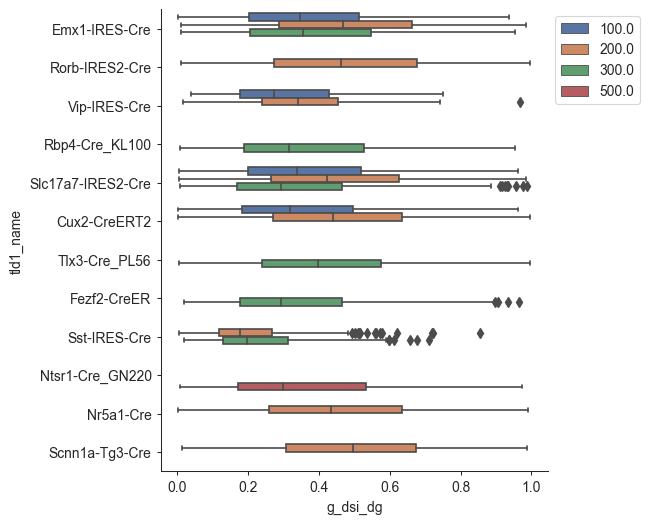

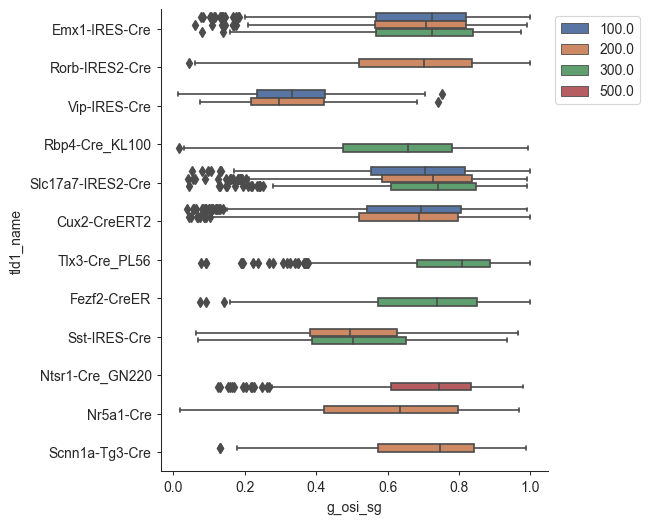

In [222]:
# for cre in ("Sst-IRES-Cre", "Vip")
plt.figure(figsize=(5, 8))
sns.boxplot(data=brain_obs_metrics[brain_obs_metrics.responsive_dg == True], y="tld1_name", x="g_osi_dg", hue="depth_range", orient="h")
plt.legend(loc="upper left", bbox_to_anchor=(1,1), bbox_transform=plt.gca().transAxes)

plt.figure(figsize=(5, 6))
sns.boxplot(data=brain_obs_metrics[brain_obs_metrics.responsive_dg == True], y="tld1_name", x="g_dsi_dg", hue="depth_range", orient="h")
plt.legend(loc="upper left", bbox_to_anchor=(1,1), bbox_transform=plt.gca().transAxes)

plt.figure(figsize=(5, 6))
sns.boxplot(data=brain_obs_metrics[brain_obs_metrics.responsive_sg == True], y="tld1_name", x="g_osi_sg", hue="depth_range", orient="h")
plt.legend(loc="upper left", bbox_to_anchor=(1,1), bbox_transform=plt.gca().transAxes)